# 1. Fitter
### Находит параметры и решение, наиболее подогнанное к данным по метрике MSE

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import sys

try:
    from tqdm.notebook import tqdm
except Exception:
    print('For a nice progress bar install tqdm (pip3 install tqdm)', file=sys.stderr)
    def tqdm(iterable, *args, **kwargs):
        return iterable

    
def progress_wrapper(iterable, level, max_progress_level):
    if level == 0:
        return tqdm(iterable)
    elif level <= max_progress_level:  # configurable
        return tqdm(iterable, leave=False)
    else:
        return iterable
    

def compute_loss(time_points, predicted_metrics, true_metrics):
    loss_sum = 0.0
    # Iterace through infected, recovered and dead
    for predicted, true in zip(predicted_metrics, true_metrics):
        assert predicted.shape[0] == true.shape[0], "expected solution's size to be {}, but got {}".format(true.shape[0], predicted.shape[0])
        loss_sum += np.mean((true - predicted) ** 2)
    return loss_sum


def fit(ode_system_getter, time_points, params, to_metrics, true_metrics, max_progress_level=1):
    """
    ode_system_getter: функция, которая получает набор параметров из params и возвращает tuple,
                       в котором первый элемент – функция, задающая систему уравнений
                       (и принимающая только параметры y и t)
                       и соответствующая аргументу func функции scipy.integrate.odeint,
                       а второй элемент – вектор начальных условий y0 функции scipy.integrate.odeint
    time_points: точки, для которых нужно решить систему уранений. Аналогично параметру t в scipy.integrate.odeint
    params: список, в котором каждый i-тый элемент –
            список возможных значений i-того параметра, передаваемого в ode_system_getter
    to_metrics: функция, принимающая solution (результат функции scipy.integrate.odeint)
                и отдающая список метрик, по которым будет производиться оценка параметров.
                каждая метрика – одномерный numpy-массив значений
    true_metrics: список метрик для данных, под которые мы подстраиваемся
                  каждая метрика – одномерный numpy-массив значений
    max_progress_level: глубина вложенных циклов, для которых будет отображаться progress-bar. Считается от 0.
                  
    
    """
    
    def fit_stage(left_params, current_values, level):
        if left_params:
            best_loss = None
            best_solution = None
            best_params = None
            for param_value in progress_wrapper(left_params[-1], level, max_progress_level):
                new_values = current_values + (param_value,)
                return_value = fit_stage(left_params[:-1], new_values, level+1)
                if return_value is None:
                    continue
                loss, solution, params_for_loss = return_value
                if best_loss is None or best_loss > loss:
                    best_loss = loss
                    best_solution = solution
                    best_params = params_for_loss
            return best_loss, best_solution, best_params
        else:
            return_value = ode_system_getter(*current_values)
            if return_value is None:  # e.g. invalid parameters
                return None
            ode_system, initial_conditions = return_value
            solution = odeint(ode_system, initial_conditions, time_points)
            loss = compute_loss(time_points, to_metrics(solution), true_metrics)
            return loss, solution, current_values
    
    best_loss, best_solution, best_params = fit_stage(params, tuple(), 0)
    return best_loss, best_solution, tuple(reversed(best_params))

# 2. Пример использования для простой SIR-модели

### Так задаются все входные данные

In [2]:
# Список возможных значений параметров SIR-модели
params = [  
    np.linspace(0.01, 1, 200),  # beta:  0.01...1
    np.linspace(0.01, 1, 200),  # gamma: 0.01...1
]

# Функция, которая принимает параметры beta и gamma и отдаёт систему уравнений и начальные условия
def func_getter(beta, gamma):
    initial_conditions =np.zeros(3)
    initial_conditions[0] = 99
    initial_conditions[1] = 1
    
    def ode_system(y,t): 
        dy=[0,0,0]
        dy[0] = -beta*y[1]*y[0]/99  # S
        dy[1] = beta*y[1]*y[0]/99 - gamma*y[1]  # I
        dy[2] = gamma*y[1]

        return dy
    
    return ode_system, initial_conditions

# Функция, по решению отдающая метрики
def solution_to_metrics(solution):
    return solution[:, 0], solution[:, 1], solution[:, 2]

# "Реальные" данные, под которые мы будем подстраиваться
time_points = [0, 10, 20]
true_data = [
    np.array([99, 50, 0]),
    np.array([1,   40, 1]),
    np.array([0, 10, 99]),
]

### Поиск наилучшего решения

In [3]:
loss, best_solution, best_params = fit(
    func_getter,
    time_points,  # [0, 10, 20]
    params,
    solution_to_metrics,
    true_data,
    max_progress_level=0,  # вложенный прогресс-бар тут только мельтешит
)
print(loss, best_params)


318.43519876885944 (0.21396984924623116, 0.6865829145728644)


In [20]:
# Небольшая функция для быстрой отрисовки графичков. Можно переиспользовать
def plot_data(time_points, data, upper_limit, labels=None):
    susceptible, infected, recovered = true_data
    
    plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    for y in data:
        plt.plot(time_points, y)
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    if labels:
        plt.legend(labels)
    plt.ylim([0, upper_limit])

    #Same plot but on log scale
    plt.subplot(1,2,2)
    for y in data:
        plt.plot(time_points, y)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    if labels:
        plt.legend(labels)
    plt.ylim([0.001, upper_limit])

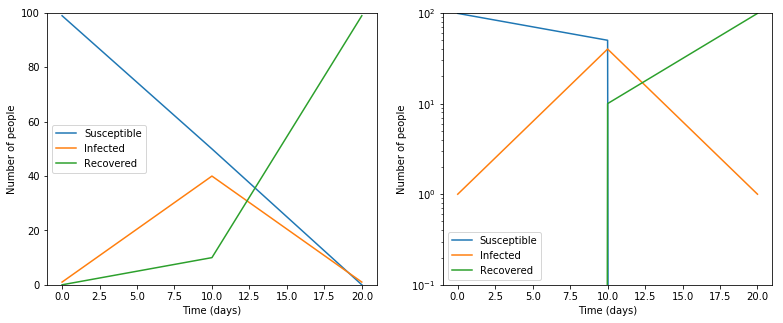

In [8]:
# "Реальные" данные
plot_data(time_points, true_data, 100, labels=["Susceptible", "Infected", "Recovered"])

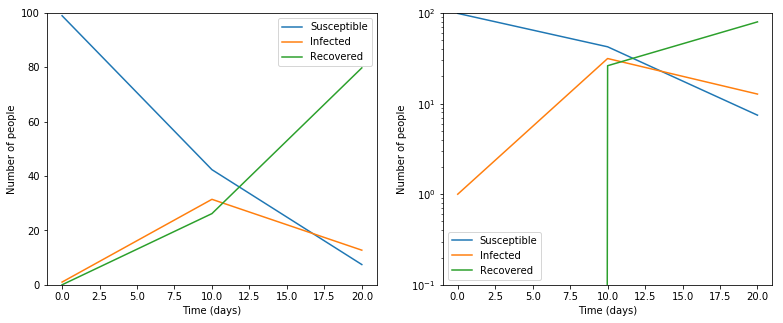

In [9]:
# Модель с наилучшими параметрами
plot_data(time_points, solution_to_metrics(best_solution), 100, labels=["Susceptible", "Infected", "Recovered"])

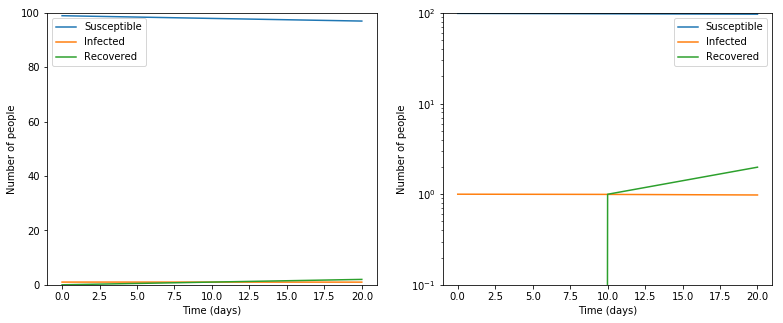

In [11]:
# Рандомно выбранные параметры (плохие)
func, ic = func_getter(0.1, 0.1)
solution = odeint(func, ic, time_points)
plot_data(time_points, solution_to_metrics(solution), 100, labels=["Susceptible", "Infected", "Recovered"])

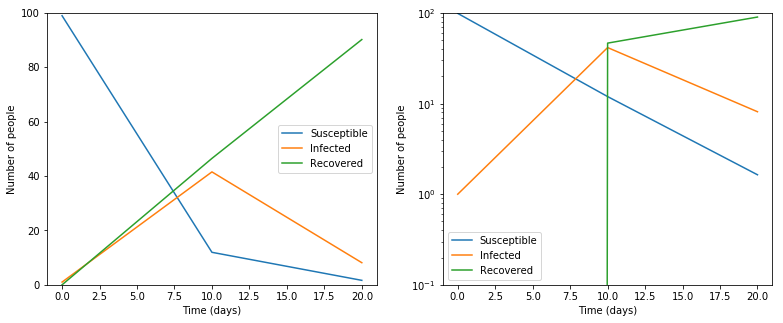

In [12]:
# Другие рандомно выбранные параметры (получше, но опять же плохие)
func, ic = func_getter(0.9, 0.2)
solution = odeint(func, ic, time_points)
plot_data(time_points, solution_to_metrics(solution), 100, labels=["Susceptible", "Infected", "Recovered"])

# 3. Пример модели из найденного нами блокнота про COVID:
## (получилось не особо хорошо)

In [23]:
import pandas as pd

N=1000

# params = [  
#     [6, 7, 8, 9, 10, 11, 12],                                     # IncubPeriod
#     [6, 7, 8, 9, 10],                                             # DurMildInf  
#     [0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925],           # FracMild
#     [0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25],            # FracSevere
#     # FracCritical – autocomputed                                 # FracCritical
#     [0.002, 0.0025, 0.005, 0.006, 0.008, 0.01, 0.02, 0.05, 0.1],  # CFR
#     [5, 6, 7, 8, 9, 10, 11, 12],                                  # TimeICUDeath
#     [13, 14, 15, 16, 17, 18, 19, 20, 21],                         # DurHosp
# ]
params = [  
    [8, 9, 10, 11, 12],                                     # IncubPeriod
    [6, 7, 8, 9, 10],                                             # DurMildInf  
    [0.75, 0.775, 0.8, 0.825, 0.85],           # FracMild
    [0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225],            # FracSevere
    # FracCritical – autocomputed                                 # FracCritical
    [0.005, 0.006, 0.008, 0.01, 0.02, 0.05, 0.1],  # CFR
    [6, 7, 8, 9, 10, 11],                                  # TimeICUDeath
    [16, 17, 18, 19, 20, 21],                         # DurHosp
]

def func_getter(IncubPeriod, DurMildInf, FracMild, FracSevere, CFR, TimeICUDeath, DurHosp):
    # Если набор параметров невалиден, можно просто вернуть None, тогда такой набор будет пропущен
    if FracMild + FracSevere > 1:
        return None
    FracCritical = 1 - FracMild - FracSevere
    
    b=np.zeros(4)
    g=np.zeros(4)
    p=np.zeros(3)

    a=1/IncubPeriod
    u=(1/TimeICUDeath)*(CFR/FracCritical)
    g[3]=(1/TimeICUDeath)-u
    p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
    g[2]=(1/DurHosp)-p[2]
    g[1]=(1/DurMildInf)*FracMild
    p[1]=(1/DurMildInf)-g[1]
    b=2.5e-4*np.array([0,1,0,0])
    
    initial_conditions =np.zeros(6)
    initial_conditions[0] = 1
    
    def ode_system(y,t): 
        # Функция с системой НЕ ПРИНИМАЕТ дополнительные параметры,
        # Но они автоматически "подсасываются" из-за вложенности в func_getter
        dy=[0,0,0,0,0,0]
        S=N-sum(y);
        dy[0] = np.dot(b[1:3],y[1:3])*S-a*y[0] # E
        dy[1] = a*y[0]-(g[1]+p[1])*y[1] #I1
        dy[2] = p[1]*y[1] -(g[2]+p[2])*y[2] #I2
        dy[3] = p[2]*y[2] -(g[3]+u)*y[3] #I3
        dy[4] = np.dot(g[1:3],y[1:3]) #R
        dy[5] = u*y[3] #D

        return dy
    
    return ode_system, initial_conditions

# Наши метрики: infected, recovered, dead
def solution_to_IRD(solution):
    # В нашем случае solution=[susceptible, mild, severe, icu, recovered, dead]
    infected = solution[:, 1] + solution[:, 2] + solution[:, 3]  # i1+i2+i3, without E
    recovered = solution[:, 4]
    dead = solution[:, 5]
    return infected, recovered, dead

# Чутка переделанные метрики: выводим число заболевших на 1000 человек
data = pd.read_csv('https://raw.githubusercontent.com/apugachev/covid-project/master/Moscow_Stats.csv')
MOSCOW_POPULATION = 12600000  # взято откуда-то с википедии
true_ird = (
    data['Заражений'] * 1000 / MOSCOW_POPULATION,
    data['Выздоровлений'] * 1000 / MOSCOW_POPULATION,
    data['Смертей'] * 1000 / MOSCOW_POPULATION,
)
time_points = np.arange(true_ird[0].shape[0])

In [24]:
loss, best_solution, best_params = fit(func_getter, time_points, params, solution_to_IRD, true_ird)
print(loss, best_params)


4.6756032124274665 (12, 10, 0.75, 0.2, 0.1, 11, 20)


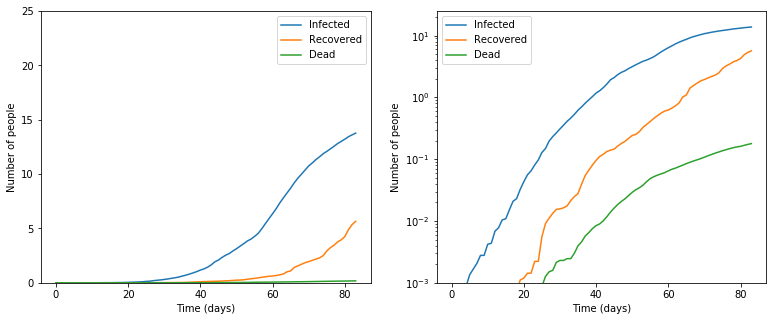

In [25]:
plot_data(time_points, true_ird, N/40, labels=["Infected", "Recovered", "Dead"])

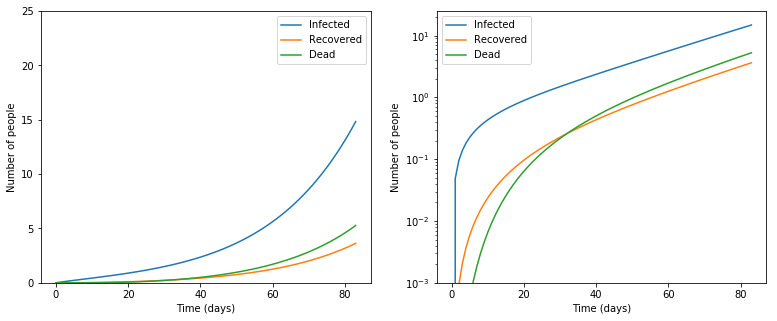

In [26]:
plot_data(time_points, solution_to_IRD(best_solution), N/40, labels=["Infected", "Recovered", "Dead"])